In [1]:
import yfinance as yf
import datetime as dt
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

import warnings
import os
import contextlib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.seasonal import seasonal_decompose

# Data

In [2]:
today = dt.datetime.today().strftime('%Y-%m-%d')
start_date = '2021-01-01'
df = yf.download('ETH-USD', start_date, today)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,737.708374,749.201843,719.792236,730.367554,730.367554,13652004358
2021-01-02,730.402649,786.798462,718.109497,774.534973,774.534973,19740771179
2021-01-03,774.511841,1006.565002,771.561646,975.507690,975.507690,45200463368
2021-01-04,977.058838,1153.189209,912.305359,1040.233032,1040.233032,56945985763
2021-01-05,1041.498779,1129.371460,986.811279,1100.006104,1100.006104,41535932781
...,...,...,...,...,...,...
2024-07-14,3176.741455,3266.487549,3166.431152,3244.079102,3244.079102,10517709666
2024-07-15,3246.131592,3494.098389,3235.776123,3489.552734,3489.552734,18305490390
2024-07-16,3486.144043,3498.218994,3351.779785,3443.513428,3443.513428,20446664416


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1295 entries, 2021-01-01 to 2024-07-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1295 non-null   float64
 1   High       1295 non-null   float64
 2   Low        1295 non-null   float64
 3   Close      1295 non-null   float64
 4   Adj Close  1295 non-null   float64
 5   Volume     1295 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 70.8 KB


In [5]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Plots

## OHLC

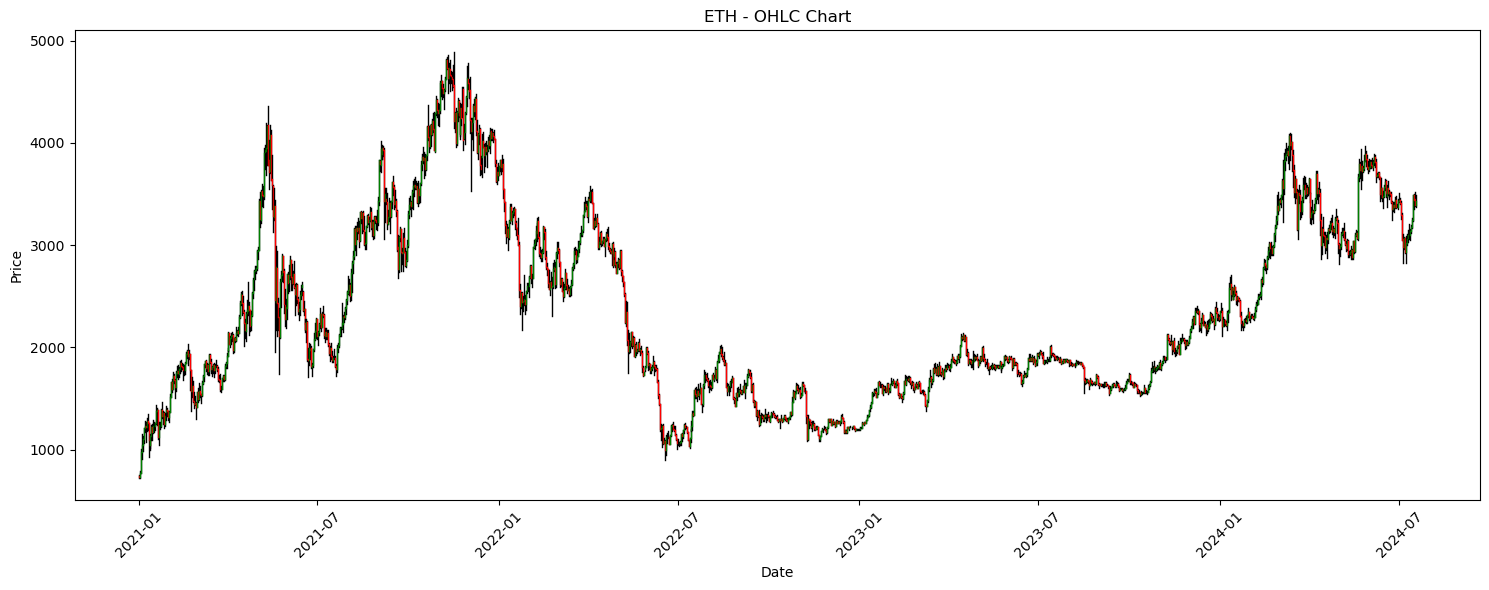

In [6]:
plt.figure(figsize=(15, 6))

for date in df.index:
    open_price = df.loc[date, 'Open']
    high_price = df.loc[date, 'High']
    low_price = df.loc[date, 'Low']
    close_price = df.loc[date, 'Close']

    if close_price >= open_price:
        color = 'green'
    else:
        color = 'red'

    plt.plot([date, date], [low_price, high_price], color='black', linewidth=1)  # High and low
    plt.plot([date, date], [open_price, close_price], color=color, linewidth=1)  # Open and close

plt.title('ETH - OHLC Chart')
plt.xlabel('Date')
plt.ylabel('Price')

plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

## Volume

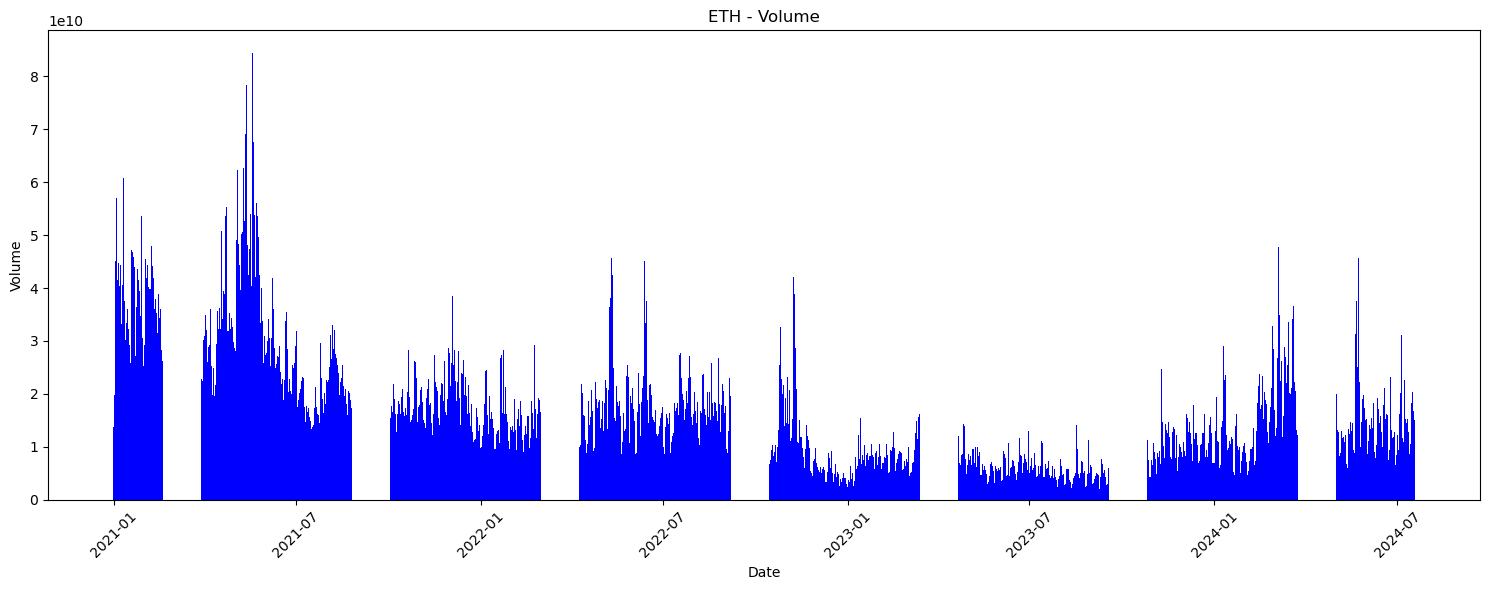

In [8]:
plt.figure(figsize=(15, 6))

plt.bar(df.index, df['Volume'], color='blue')

plt.title('ETH - Volume')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

## Decomposition

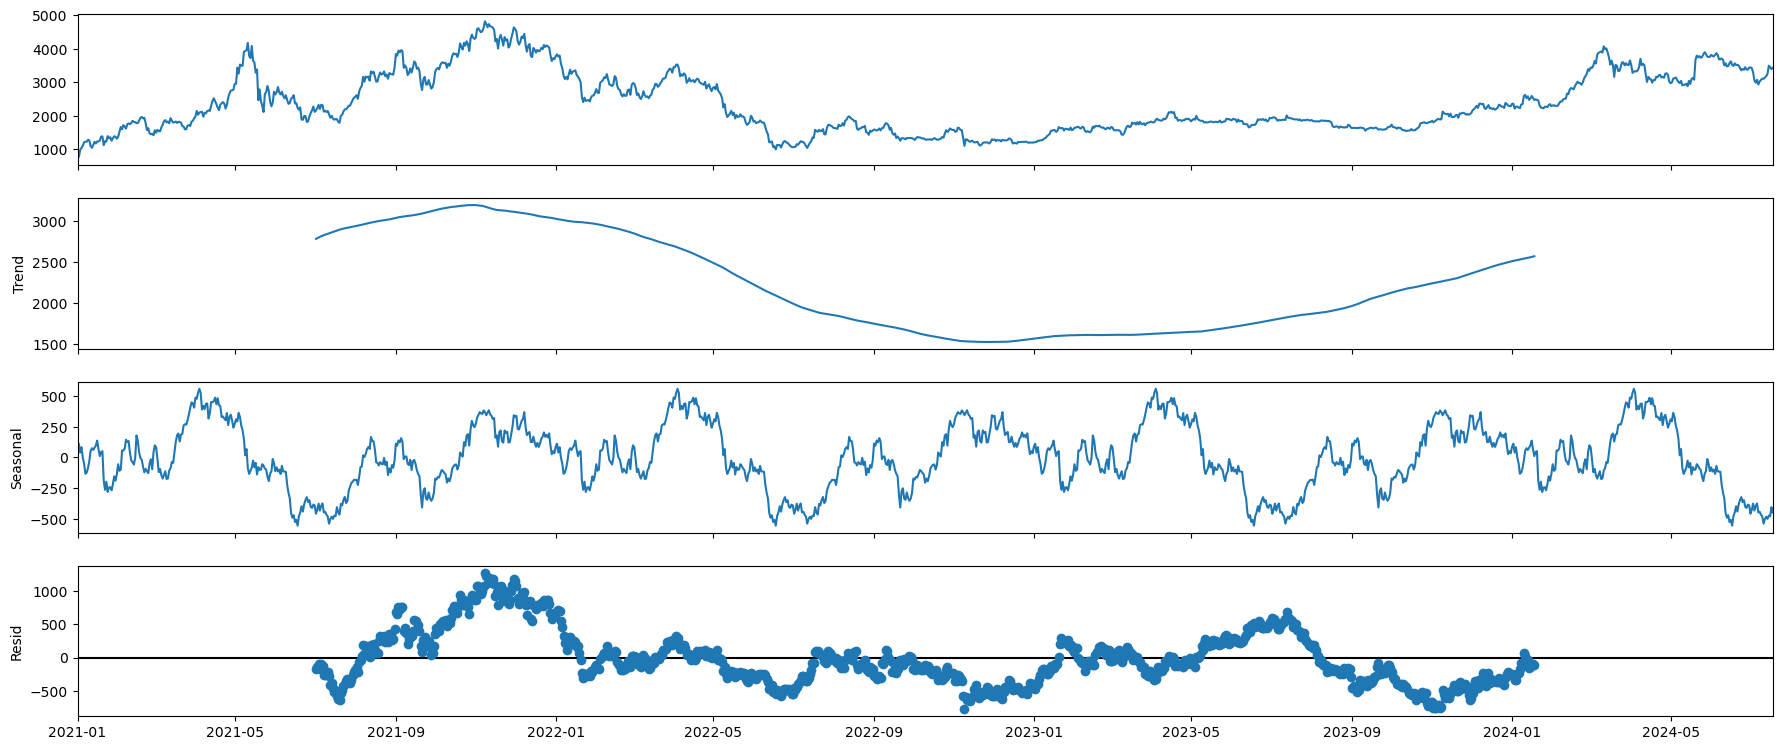

In [9]:
df_close = df[['Close']]
df_close.head()

decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

# Technical Indicators


## Stochastic Oscillator

In [10]:
def calculate_stochastic_oscillator(close_prices, high_prices, low_prices, window=14, smooth_k=3):
    highest_high = high_prices.rolling(window=window, min_periods=window).max()
    lowest_low = low_prices.rolling(window=window, min_periods=window).min()
    stochastic_k = (close_prices - lowest_low) / (highest_high - lowest_low) * 100
    stochastic_d = stochastic_k.rolling(window=smooth_k, min_periods=smooth_k).mean()
    stochastic_oscillator = pd.DataFrame({
        '%K': stochastic_k,
        '%D': stochastic_d
    })
    
    return stochastic_oscillator

In [11]:
df['Close'] = df['Close'].astype(float)  
df['High'] = df['High'].astype(float)    
df['Low'] = df['Low'].astype(float)      

stochastic_oscillator = calculate_stochastic_oscillator(df['Close'], df['High'], df['Low'])

df = df.join(stochastic_oscillator)

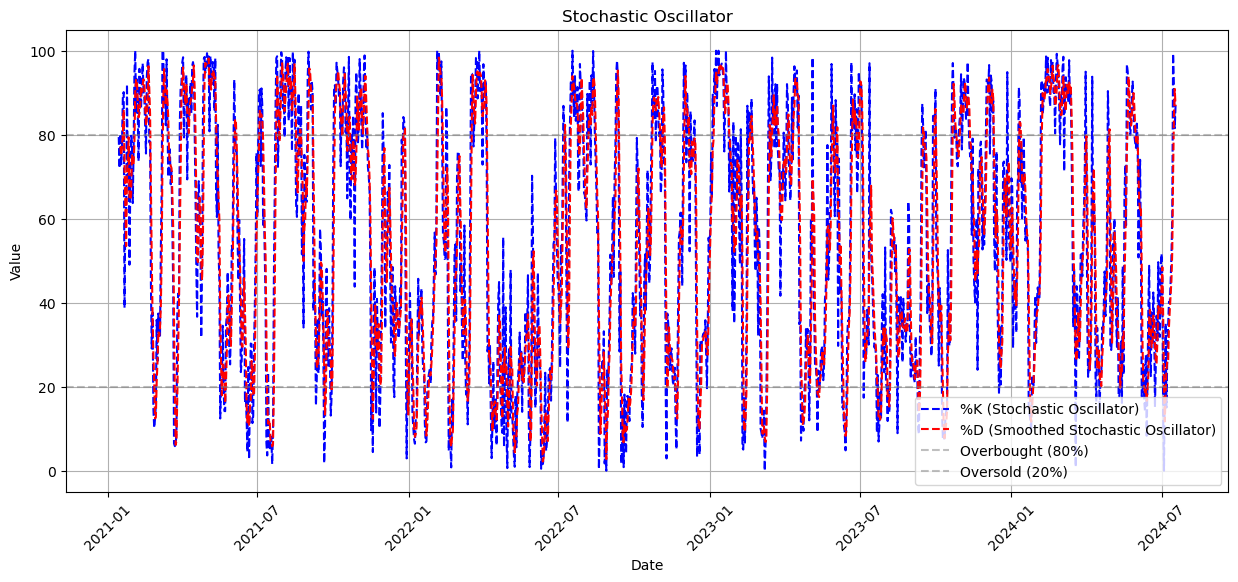

In [12]:
plt.figure(figsize=(15, 6))

plt.plot(df.index, df['%K'], label='%K (Stochastic Oscillator)', color='blue', linestyle='--')
plt.plot(df.index, df['%D'], label='%D (Smoothed Stochastic Oscillator)', color='red', linestyle='--')

plt.axhline(y=80, color='gray', linestyle='--', alpha=0.5, label='Overbought (80%)')
plt.axhline(y=20, color='gray', linestyle='--', alpha=0.5, label='Oversold (20%)')

plt.title('Stochastic Oscillator')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

## Moving Averages

In [13]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

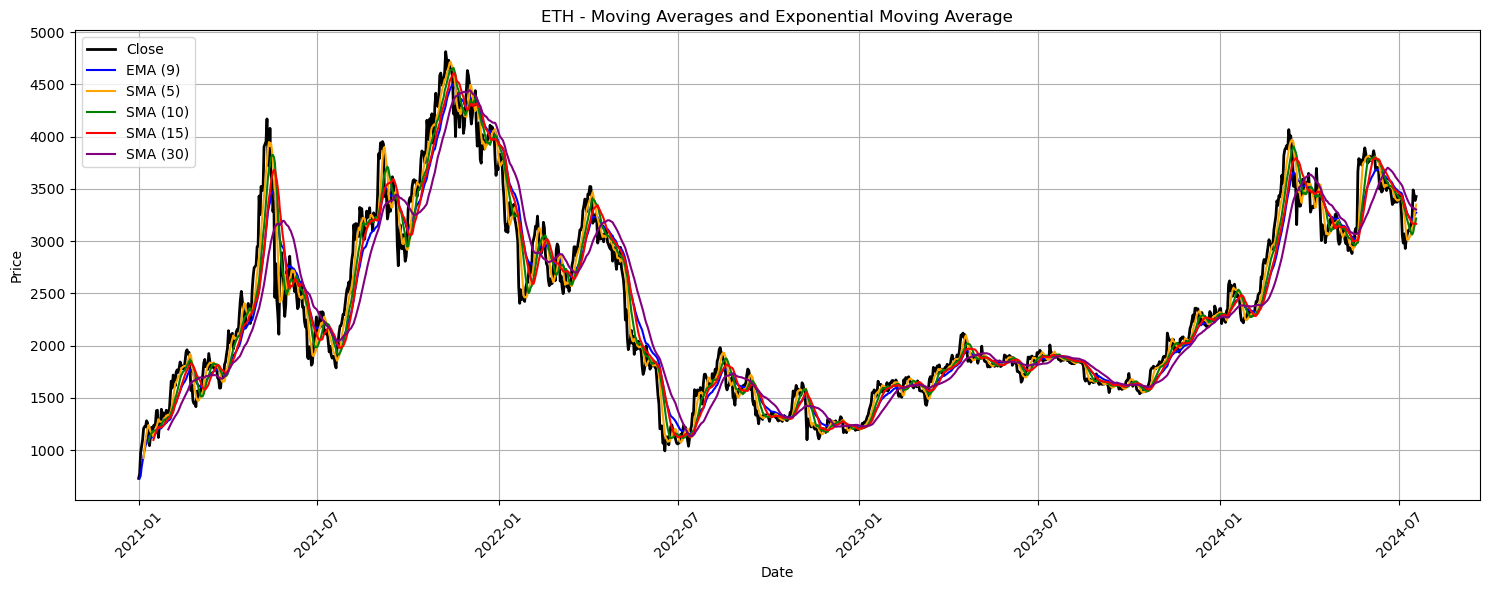

In [14]:
plt.figure(figsize=(15, 6))

plt.plot(df.index, df['Close'], label='Close', color='black', linewidth=2)

plt.plot(df.index, df['EMA_9'], label='EMA (9)', color='blue')
plt.plot(df.index, df['SMA_5'], label='SMA (5)', color='orange')
plt.plot(df.index, df['SMA_10'], label='SMA (10)', color='green')
plt.plot(df.index, df['SMA_15'], label='SMA (15)', color='red')
plt.plot(df.index, df['SMA_30'], label='SMA (30)', color='purple')

plt.title('ETH - Moving Averages and Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

## Relative Strength Index (RSI)


In [15]:
def rsi(prices, window=14):
    delta = prices.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [16]:
df['RSI'] = rsi(df_close).fillna(0)

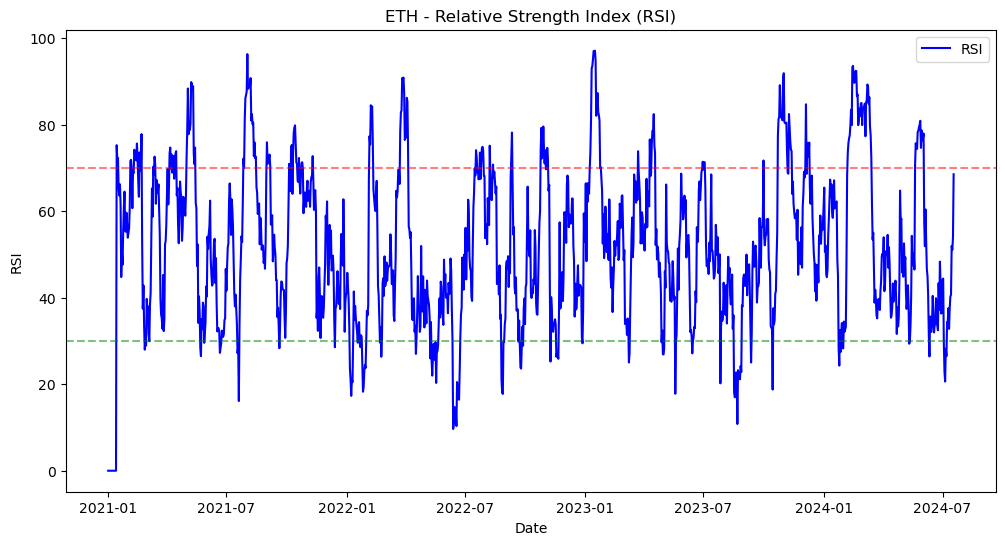

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(df['RSI'], label='RSI', color='blue')
plt.title('ETH - Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.axhline(70, linestyle='--', color='red', alpha=0.5)  # Overbought threshold
plt.axhline(30, linestyle='--', color='green', alpha=0.5)  # Oversold threshold
plt.legend()
plt.show()

## Moving Average Convergence Divergence (MACD)

In [18]:
EMA_12 = df['Close'].ewm(span=12, min_periods=12).mean()
EMA_26 = df['Close'].ewm(span=26, min_periods=26).mean()
df['MACD'] = EMA_12 - EMA_26
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

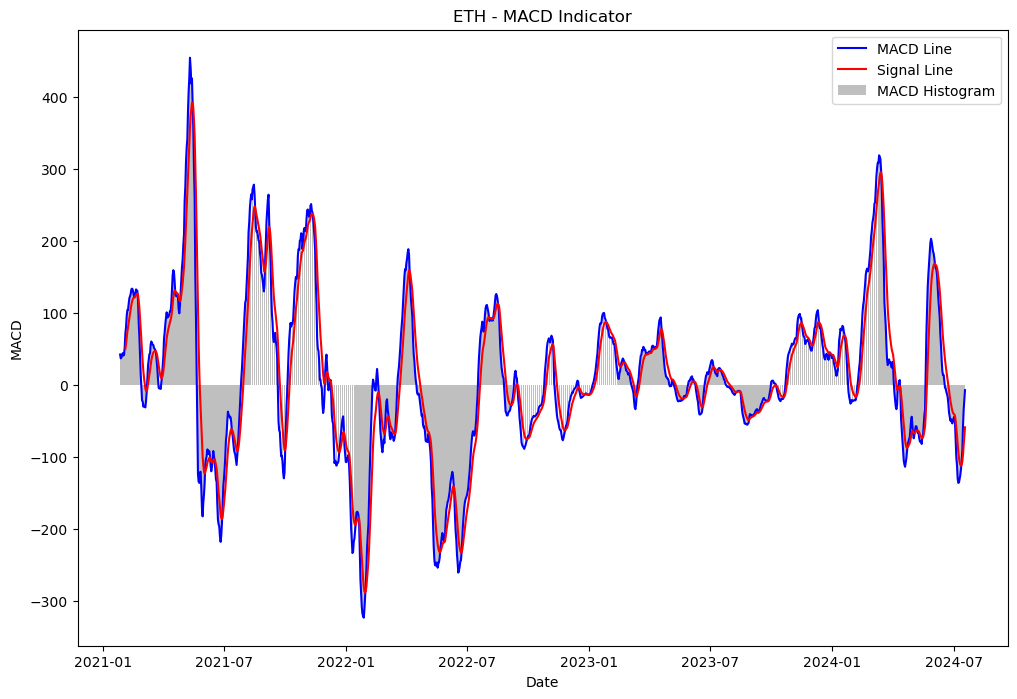

In [19]:
plt.figure(figsize=(12, 8))

plt.plot(df['MACD'], label='MACD Line', color='blue')
plt.plot(df['MACD_signal'], label='Signal Line', color='red')

plt.bar(df['MACD'].index, df['MACD'], width=0.8, color='gray', alpha=0.5, label='MACD Histogram')

plt.title('ETH - MACD Indicator')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.show()

# Data Split

In [20]:
df['Close'] = df['Close'].shift(-1)

In [21]:
df = df.dropna()

In [22]:
n = len(df_close[['Close']])
train_size = 0.7
val_size = 0.15
test_size = 0.15

train_end = int(train_size * n)
val_end = int((train_size + val_size) * n)

df_train = df.iloc[:train_end]
df_validate = df.iloc[train_end:val_end]
df_test = df.iloc[val_end:]

df_test = df.iloc[val_end:]

In [23]:
drop_cols = ['Open', 'High', 'Low', 'Adj Close']

In [24]:
df_train = df_train.drop(columns=drop_cols, errors='ignore')
df_validate = df_validate.drop(columns=drop_cols, errors='ignore')
df_test = df_test.drop(columns=drop_cols, errors='ignore')

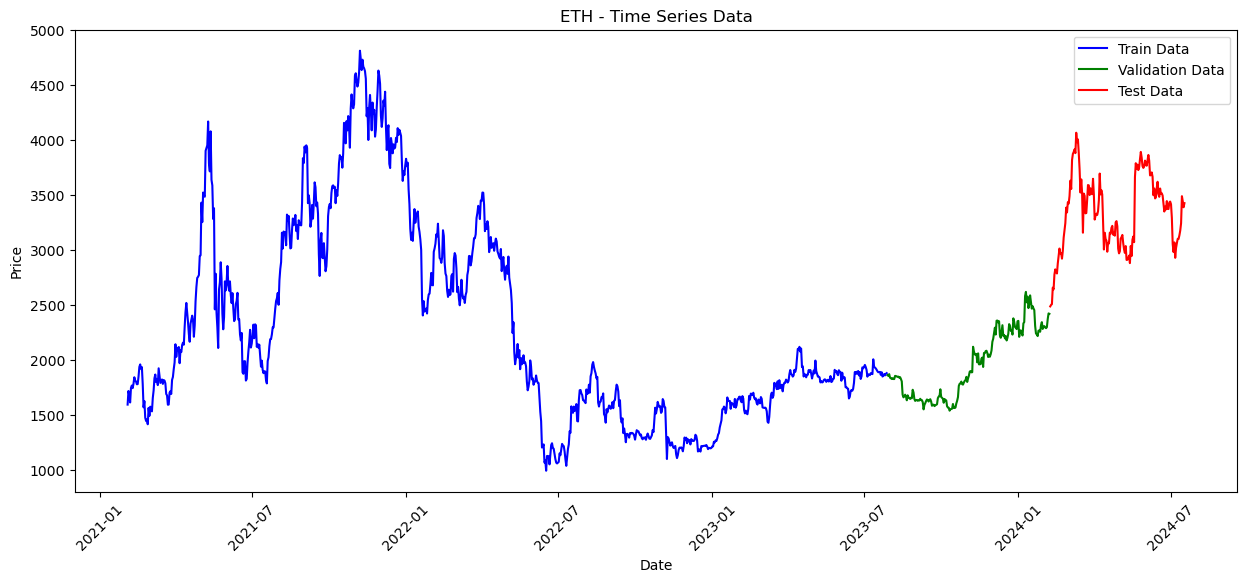

In [25]:
plt.figure(figsize=(15, 6))

plt.plot(df_train.index, df_train['Close'].values, label='Train Data', color='blue')
plt.plot(df_validate.index, df_validate['Close'].values, label='Validation Data', color='green')
plt.plot(df_test.index, df_test['Close'].values, label='Test Data', color='red')

plt.title('ETH - Time Series Data')
plt.xlabel('Date')
plt.ylabel('Price')

plt.legend()

plt.xticks(rotation=45)

plt.show()

In [26]:
y_train = df_train['Close'].copy()
X_train = df_train.drop(columns=['Close'])

y_valid = df_validate['Close'].copy()
X_valid = df_validate.drop(columns=['Close'])

y_test = df_test['Close'].copy()
X_test = df_test.drop(columns=['Close'])

## XGBoost

In [27]:
%%time

parameters = {
    'n_estimators': [5, 15, 75, 100],
    'learning_rate': [0.15, 0.25, 0.35, 0.45],
    'max_depth': [10, 11, 12, 15, 20],
    'gamma': [0.0025, 0.005, 0.01, 0.02],
    'random_state': [5, 42]
}

model = xgb.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20, verbosity=0)
warnings.filterwarnings("ignore", category=FutureWarning)

with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    clf = GridSearchCV(model, parameters, cv=3, scoring='neg_mean_squared_error', verbose=0)

    clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

print(f'Best params: {clf.best_params_}')
print(f'Best validation score (negative MSE): {clf.best_score_}')

best_model = clf.best_estimator_
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {test_mse}')

Best params: {'gamma': 0.02, 'learning_rate': 0.45, 'max_depth': 12, 'n_estimators': 15, 'random_state': 5}
Best validation score (negative MSE): -91037.32821793143
Mean Squared Error on Test Set: 48116.23981222455
CPU times: user 16min 46s, sys: 4min 3s, total: 20min 49s
Wall time: 2min 5s


In [28]:
%%time
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 604 ms, sys: 309 ms, total: 913 ms
Wall time: 118 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.02, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.45, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=15, n_jobs=None,
             num_parallel_tree=None, random_state=5, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

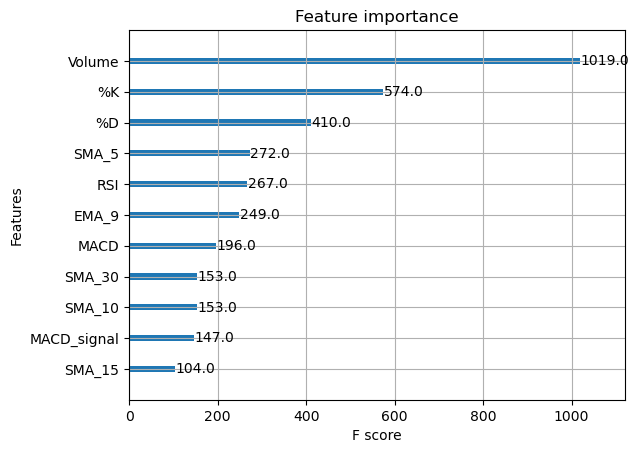

In [29]:
plot_importance(model)

# Predictions Plot

In [30]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [2487.515625   2501.22827148 2507.57055664 2658.1159668  2642.18530273]
y_pred = [2453.5928 2547.463  2552.5706 2545.4792 2515.1682]


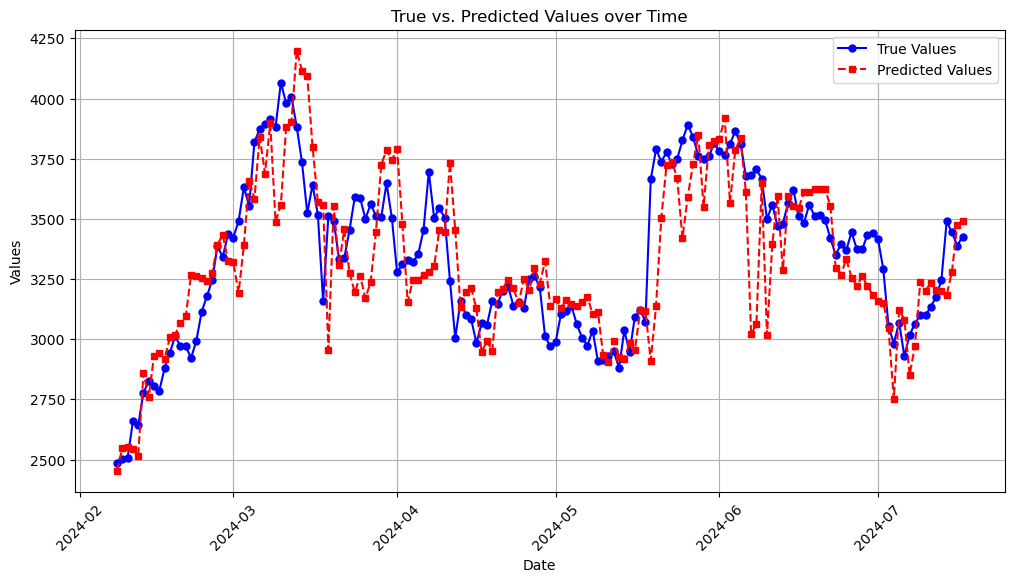

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='True Values', color='blue', linestyle='-', marker='o', markersize=5)
plt.plot(y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--', marker='s', markersize=5)
plt.title('True vs. Predicted Values over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()